In [73]:
%matplotlib inline

import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import os
import pandas as pd
import numpy as np
import random
import cv2
import csv
import os, sys, time, datetime, random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision
from torchvision import datasets, models
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from skimage import io
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import chitra
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import math

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

sys.path.append('../../vision/references/detection/')
from engine import train_one_epoch # source: https://github.com/pytorch/vision

In [74]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'
DIR_IMAGE = DIR_PATH + 'scraped_photos_final/'

In [75]:
def from_tsv_to_list(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter="\n")

    expected = list(read_tsv)
    
    return [item for sublist in expected for item in sublist]

In [76]:
# train
expected_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/expected.tsv')
in_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/in.tsv')

# val
expected_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/expected.tsv')
in_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/in.tsv')

# test
expected_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/expected.tsv')
in_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/in.tsv')

In [60]:
def show_random_img_with_all_annotations(in_list, expected_list, path_to_photos, matplotlib_colours_list, pages=5):
    for page in range(pages):
        random_img = random.randint(0,len(in_list))
        file_name = in_list[random_img]
        print(file_name)

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        annotations = expected_list[random_img].split(' ')
        for i in range(len(annotations)):
            bbox = annotations[i].split('/')[1]
            x0 = int(bbox.split(',')[0])
            y0 = int(bbox.split(',')[1])
            width = int(bbox.split(',')[2])
            height = int(bbox.split(',')[3])
            cat_id = int(annotations[i].split('/')[0])
            rect = matplotlib.patches.Rectangle(
                (x0, y0), 
                width, 
                height, 
                linewidth=1, 
                edgecolor=matplotlib_colours_list[cat_id], 
                facecolor='none'
            )
                
            ax.add_patch(rect)           
            ax.text(
                x0, 
                y0, 
                cat_id, 
                fontsize=8,
                backgroundcolor='black',
                color=matplotlib_colours_list[cat_id]
            )

        plt.show()

2302.jpg


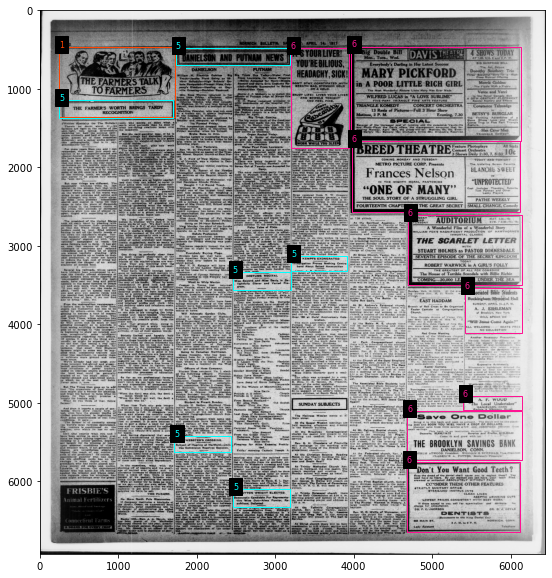

3295.jpg


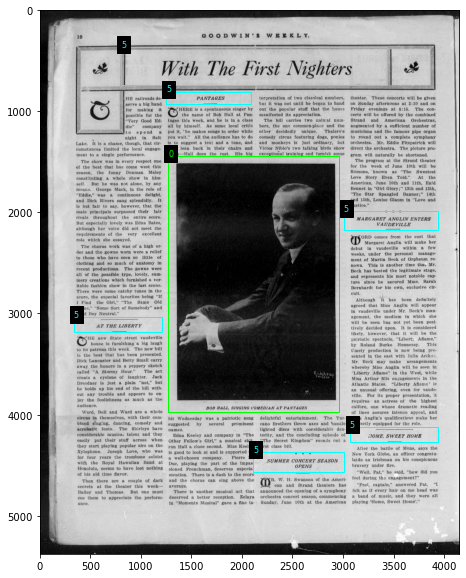

2533.jpg


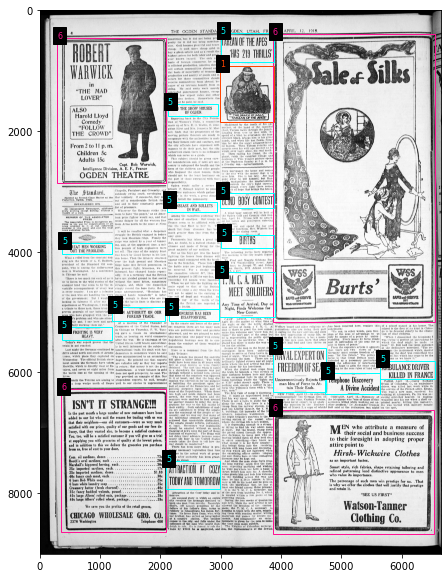

659.jpg


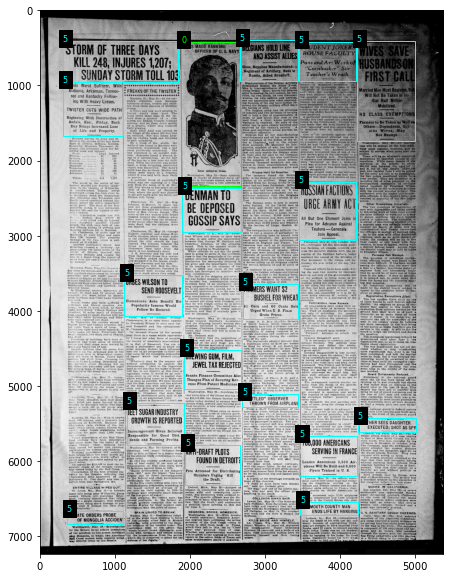

3059.jpg


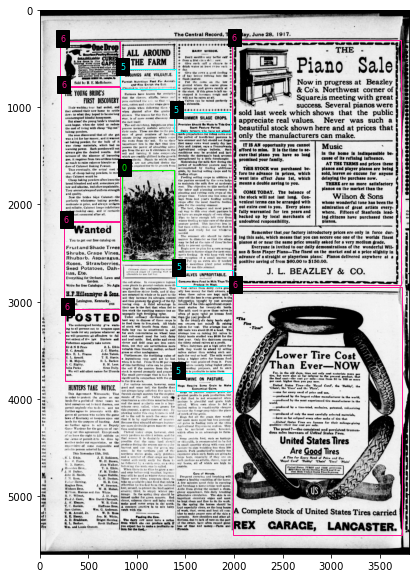

In [61]:
# some random images with annotations
show_random_img_with_all_annotations(
    in_train,
    expected_train,
    DIR_IMAGE,
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
    5
)

In [63]:
class NewspapersDataset(Dataset):
    def __init__(self, img_dir, in_list, expected_list, scale=None, transforms=None):
        # selfs
        self.img_dir = img_dir
        self.transforms = transforms
        self.in_list = in_list
        self.expected_list = expected_list
        self.scale = scale
        
        # read gonito format files and rescale annotations (optional)
        self.df = pd.DataFrame()
        for i in range(len(self.in_list)):
            img_width, img_height = get_image_size.get_image_size(
                self.img_dir+self.in_list[i]
            )
            expected_list_split = self.expected_list[i].split(' ')
            for ii in range(len(expected_list_split)):
                expected_list_split_2 = expected_list_split[ii].split('/')
                bbox = expected_list_split_2[1].split(',')
                if isinstance(self.scale, list):
                    new_img_width, new_img_height = self.scale[0], self.scale[1]
                elif isinstance(self.scale, int) or isinstance(self.scale, float):
                    new_img_width, new_img_height = img_width*self.scale, img_height*self.scale
                else:
                    new_img_width, new_img_height = img_width, img_height
                x0, y0 = int(bbox[0]), int(bbox[1])
                x1, y1 = x0+int(bbox[2]), y0+int(bbox[3])              
                temp_dict = {
                    'file_name': self.in_list[i],
                    'class': expected_list_split_2[0],
                    'x0': int(x0/(img_width/(new_img_width))),
                    'y0': int(y0/(img_height/(new_img_height))),
                    'x1': int(x1/(img_width/(new_img_width))),
                    'y1': int(y1/(img_height/(new_img_height))),
                    'new_width': int(new_img_width),
                    'new_height': int(new_img_height)
                }
                self.df = self.df.append(temp_dict, ignore_index=True)
    
    def __getitem__(self, index):
        # read images
        img_name = self.df.file_name[index]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path)
        temp_df = self.df[self.df.file_name == img_name]
        temp_df = temp_df.reset_index(drop=True)
        
        # resize
        if self.scale:
            img = img.resize((int(temp_df['new_width'][0]), int(temp_df['new_height'][0])))
    
        # get bboxes and labels
        boxes, labels = [], []
        for i in range(len(temp_df)):
            x0, y0 = temp_df['x0'][i], temp_df['y0'][i] 
            x1, y1 = temp_df['x1'][i], temp_df['y1'][i]
            boxes.append([x0, y0, x1, y1])
            labels.append(int(temp_df['class'][i]))
            
        # transformation to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        image_id = torch.tensor([index])
        
        # wrapping
        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": image_id
        }
        
        # data transformation
        if self.transforms:            
            img = self.transforms(img) 
        
        return img, target
    
    def __len__(self):
        return len(self.in_list)

In [64]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [65]:
# hyperparameters
CHANNEL = 1 
NUM_CLASSES = 8 # 7 classes, but there is also one for background
LEARNING_RATE = 5e-3
BATCH_SIZE = 32
NUM_EPOCHS = 10
RESCALE = 1/6 # if float, each image will be multiplied by it, if list [width, heihgt] each image will be scaled to that size (concerns both images + annotations)
SHUFFLE = True

In [66]:
# load datasets
data_transform = T.Compose([
    T.Grayscale(num_output_channels=CHANNEL),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
])

train_dataloader = DataLoader(
    NewspapersDataset(
        img_dir=DIR_IMAGE,
        in_list=in_train, 
        expected_list=expected_train,
        scale=RESCALE,
        transforms=data_transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    NewspapersDataset(
        img_dir=DIR_IMAGE,
        in_list=in_val, 
        expected_list=expected_val,
        scale=RESCALE,
        transforms=data_transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    NewspapersDataset(
        img_dir=DIR_IMAGE,
        in_list=in_test, 
        expected_list=expected_test,
        scale=RESCALE,
        transforms=data_transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    collate_fn=collate_fn
)

In [19]:
# little check if everything is good inside dataloader
images, targets = next(iter(val_dataloader))

print(
    'First element of first batch:', '\n\n', images[0], '\n\n', targets[0], '\n\n\n',
    'Last element of first batch:', '\n\n', images[len(images)-1], '\n\n', targets[len(targets)-1],  
)

First element of first batch: 

 tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.2941,  0.2941,  0.2235,  ..., -0.9843, -0.9922, -0.9922],
         [ 0.2941,  0.2941,  0.2471,  ..., -0.9843, -0.9922, -0.9922],
         [ 0.2627,  0.2784,  0.2706,  ..., -0.9922, -0.9843, -0.9922]]]) 

 {'boxes': tensor([[ 655.,  985., 1094., 1482.],
        [  44.,  126.,  338.,  565.],
        [ 345.,  122.,  491.,  248.],
        [ 489.,  121.,  642.,  261.],
        [  35.,  671.,  339.,  755.],
        [ 343.,  591.,  495.,  655.],
        [ 494.,  458.,  644.,  539.],
        [ 640.,  297.,  799.,  361.],
        [ 797.,  430.,  952.,  490.],
        [ 649.,  461.,  801.,  523.],
        [ 649.,  647.,  801.,  707.],
        [ 496.,  758.,  649.,  818.],
        [ 345.,  881.,  498.,  946.],
        [ 651.,  8

In [20]:
# pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)

In [21]:
anchor_generator = AnchorGenerator(
    sizes=tuple([(16, 32, 64, 128, 256) for _ in range(5)]), 
    aspect_ratios=tuple([(0.75, 0.5, 1.25) for _ in range(5)])
) 

In [47]:
rpn_head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])

In [48]:
model.rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator, 
    head=rpn_head,
    fg_iou_thresh=0.7, 
    bg_iou_thresh=0.3,
    batch_size_per_image=BATCH_SIZE, 
    positive_fraction = 0.5,
    pre_nms_top_n=dict(training=200, testing=100),
    post_nms_top_n=dict(training=160, testing=80),
    nms_thresh=0.7
)

In [49]:
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=NUM_CLASSES)
model.roi_heads.fg_bg_sampler.batch_size_per_image=BATCH_SIZE
model.roi_heads.fg_bg_sampler.positive_fraction = 0.5

In [50]:
# # freeze layers (gradient will not be calculated during backpropagation)
# for i, param in enumerate(model.parameters()):
#     if i < 15:
#         param.requires_grad = False 

In [51]:
# optimizer 
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=LEARNING_RATE,
    weight_decay=5e-4
)

In [52]:
# learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [53]:
# switch to gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [54]:
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def train_model(model, optimizer, train_dataloader, val_dataloader = None, lr_scheduler = None)
    start_time = datetime.datetime.now()
    print(f'Start time: {start_time} \n')
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        for images, targets in train_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # clear the gradients
            optimizer.zero_grad()
            # forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            if not math.isfinite(loss_value):
                print(f"ERROR: Loss is {loss_value}, stopping training")
                sys.exit(1)
            # calculate gradients
            losses.backward()
            # update weights
            optimizer.step()
            # calculate loss
            train_loss += loss_value
            
        train_print = f'{datetime.datetime.now()} - epoch {epoch+1}: train_loss = {train_loss / len(train_dataloader)}'
    
        if val_dataloader:
            model.eval()
            train_loss = 0.0
            for images, targets in val_dataloader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = model(images)
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()
                if not math.isfinite(loss_value):
                    print(f"ERROR: Loss is {loss_value}, stopping training")
                    sys.exit(1)
                val_loss += loss_value

            print(train_print + f' val_loss = {val_loss / len(val_dataloader)}')
        else:
            print(train_print)
         
        if lr_scheduler:
            lr_scheduler.step()

    print(f'\nModel training completed, runtime: {datetime.datetime.now()-start_time}') 
    
    return model

In [ ]:
train_model(model, optimizer, train_dataloader, val_dataloader=val_dataloader, lr_scheduler=lr_scheduler)

# ARCHIVE:

In [ ]:
# =============== 0 =============== #

In [55]:
start_time = datetime.datetime.now()
model.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
#    for images, targets in tqdm(train_dataloader):
    for images, targets in tqdm(val_dataloader):
        print('1 passed')
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print('2 passed')
        # clear the gradients
        optimizer.zero_grad()
        print('3 passed')
        # forward pass
        loss_dict = model(images, targets)
        print('4 passed')
        losses = sum(loss for loss in loss_dict.values())
        print('5 passed')            
        loss_value = losses.item()
        print('6 passed') 
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            sys.exit(1)
        print('7 passed')  
        # calculate gradients
        losses.backward()
        print('8 passed')
        # update weights
        optimizer.step()
        print('9 passed')
        # calculate loss
        train_loss += loss_value
    
#     print(f'{datetime.datetime.now()} - epoch {epoch+1}: loss = {train_loss / len(train_dataloader)}')
    print(f'{datetime.datetime.now()} - epoch {epoch+1}: loss = {train_loss / len(val_dataloader)}')

    lr_scheduler.step()
    
print(f'\nModel training completed, runtime: {datetime.datetime.now()-start_time}') 

  0%|          | 0/7 [00:00<?, ?it/s]

1 passed
2 passed
3 passed
4 passed
5 passed
6 passed
7 passed
8 passed


 14%|█▍        | 1/7 [12:24<1:14:25, 744.18s/it]

9 passed
1 passed
2 passed
3 passed


 14%|█▍        | 1/7 [15:52<1:35:17, 952.99s/it]


KeyboardInterrupt: 

In [ ]:
# =============== 1 =============== #

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
# =============== 2 =============== #

In [ ]:
# train and val loop
model.train()
num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    for images, labels in iter(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
    test_error_count = 0.0
    for images, labels in iter(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))
    
    test_accuracy = 1.0 - float(test_error_count) / float(len(expected_val))
    print('%d: %f' % (epoch, test_accuracy))

In [ ]:
# =============== 3 =============== #

In [ ]:
# https://colab.research.google.com/drive/1NziO_b-SW9KmWFh-6C8to9H_QAdpmCBZ?usp=sharing#scrollTo=PLGLZVbRh_k4

In [ ]:
# =============== 4 =============== #

In [ ]:
# pre-trained model
resnet50 = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)

resnet50.out_channels = 1280

In [ ]:
# freeze layers (gradient will not be calculated during backpropagation)
for param in resnet50.parameters():
    param.requires_grad = False

params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
# we need to change the predictor layers to match the number of classes in our custom dataset
resnet50.roi_heads.box_predictor.cls_score = nn.Linear(
    resnet50.roi_heads.box_head.fc7.out_features, 
    out_features=NUM_CLASSES
) 
resnet50.roi_heads.box_predictor.bbox_pred = nn.Linear(
    resnet50.roi_heads.box_head.fc7.out_features, 
    out_features=NUM_CLASSES*4
)

In [ ]:
# the optimizer needs to be modified (because of frozen parameters) to only get the parameters with requires_grad=True
optimizer = optim.Adam(
    params,
#     filter(lambda p: p.requires_grad, model.parameters()), 
    lr=LEARNING_RATE,
    weight_decay=5e-4
)

In [ ]:
# learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
# main model
model = FasterRCNN(
    backbone=resnet50,
    num_classes=NUM_CLASSES,
)

In [ ]:
# switch to gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# move model to the right device
model.to(device)

In [ ]:
model.train()
for images, targets in tqdm(val_dataloader):
    model(images, targets=targets)

In [ ]:
# ATTENTION:
# the following code is under construction
start_time = datetime.datetime.now()
model.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
#    for images, targets in tqdm(train_dataloader):
    for images, targets in tqdm(val_dataloader):
        # clear the gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(images, targets)
        # loss
        loss = F.cross_entropy(outputs, targets)
        # calculate gradients 
        loss.backward()
        # update weights
        optimizer.step()
        # calculate loss
        train_loss += loss.item()
    
#     print(f'{datetime.datetime.now()} - epoch {epoch+1}: loss = {train_loss / len(train_dataloader)}')
    print(f'{datetime.datetime.now()} - epoch {epoch+1}: loss = {train_loss / len(val_dataloader)}')

    lr_scheduler.step()
    
print(f'\nModel training completed, runtime: {datetime.datetime.now()-start_time}') 

In [ ]:
# =============== 5 =============== #

In [479]:
backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=5)

In [480]:
anchor_generator = AnchorGenerator(
    sizes=((16,), (32,), (64,), (128,), (256,)),
    aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)])
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],
    output_size=7, 
    sampling_ratio=2
)

In [481]:
# put the pieces together inside a FasterRCNN model
model = FasterRCNN(
    backbone, 
    num_classes=NUM_CLASSES,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
# =============== 6 =============== #

In [479]:
backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=5)

In [480]:
anchor_generator = AnchorGenerator(
    sizes=((16,), (32,), (64,), (128,), (256,)),
    aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)])
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],
    output_size=7, 
    sampling_ratio=2
)

In [481]:
# put the pieces together inside a FasterRCNN model
model = FasterRCNN(
    backbone, 
    num_classes=NUM_CLASSES,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
# =============== 7 =============== #

In [ ]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

In [ ]:
# =============== 8 =============== #
# https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

In [ ]:
# =============== 9 =============== #

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [109]:
targets

({'boxes': tensor([[ 644.,  961., 1084., 1496.],
          [ 654.,   95., 1105.,  774.],
          [  38.,  163.,  192.,  242.],
          [  34.,  543.,  188.,  630.],
          [  34., 1047.,  189., 1132.],
          [ 191.,  775.,  341.,  862.],
          [ 195.,  586.,  342.,  671.],
          [ 335.,  592.,  493.,  673.],
          [ 498.,  599.,  653.,  662.],
          [ 953.,  773., 1103.,  856.]]),
  'labels': tensor([3, 6, 5, 5, 5, 5, 5, 5, 5, 5]),
  'area': tensor([235400., 306229.,  12166.,  13398.,  13175.,  13050.,  12495.,  12798.,
            9765.,  12450.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'image_id': tensor([54])},
 {'boxes': tensor([[ 476.,  273.,  681.,  563.],
          [  38.,  111.,  682.,  255.],
          [ 146.,  376.,  250.,  503.],
          [ 252.,  371.,  469.,  547.],
          [  41.,  260.,  140.,  439.],
          [  38.,  506.,  253.,  798.],
          [  35.,  804.,  254., 1042.],
          [ 250.,  559.,  462., 1038.],
      

In [114]:
targets

({'boxes': tensor([[ 476.,  273.,  681.,  563.],
          [  38.,  111.,  682.,  255.],
          [ 146.,  376.,  250.,  503.],
          [ 252.,  371.,  469.,  547.],
          [  41.,  260.,  140.,  439.],
          [  38.,  506.,  253.,  798.],
          [  35.,  804.,  254., 1042.],
          [ 250.,  559.,  462., 1038.],
          [ 465.,  585.,  681.,  886.],
          [ 466.,  889.,  677., 1039.]]),
  'labels': tensor([0, 0, 0, 0, 0, 6, 6, 6, 6, 6]),
  'area': tensor([ 59450.,  92736.,  13208.,  38192.,  17721.,  62780.,  52122., 101548.,
           65016.,  31650.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'image_id': tensor([69])},
 {'boxes': tensor([[ 343.,   46.,  449.,  277.],
          [  24.,   41.,  133.,  179.],
          [ 134.,   44.,  343.,  120.],
          [ 444.,   47.,  552.,  123.],
          [ 657.,   48.,  762.,  124.],
          [ 553.,  169.,  657.,  204.],
          [ 239.,  414.,  343.,  449.],
          [ 237.,  534.,  345.,  569.],
      

In [ ]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_object_detection_model(NUM_CLASSES)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [ ]:
for epoch in tqdm(range(NUM_EPOCHS)):
    # training for one epoch
    train_one_epoch(model, optimizer, val_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()